In [ ]:
#@title # Setting up the environment { vertical-output: true, display-mode: "form" }

###################
#####  SETUP  #####
###################

#@title Setting up project paths
import os

colab_setup = True #@param {type:"boolean"}
PROJECT_PATH = "/content/drive/MyDrive/TWM/Graduation-Project/" #@param {"type":"string"}

if colab_setup:
    from google.colab import drive
    print("Mounting Google Drive...", end="", flush=True)
    drive.mount('/content/drive')
    print("Done")

else:
    # set this to the parent directory of the whole project
    PROJECT_PATH = rf"C:\Users\{os.environ['USERNAME']}\Graduation-Project"

print("PROJECT_PATH:", PROJECT_PATH)
os.chdir(PROJECT_PATH)
os.listdir()

PROJECT_PATH: C:\Users\LAPTOP\Graduation-Project


['.git',
 '.gitignore',
 'chatbot-env',
 'DataEngineering',
 'Dependencies',
 'FineTuneing',
 'hierarchy.txt',
 'MergedDataset',
 'requirements.txt',
 'Testing Interface.ipynb',
 'Utils']

In [ ]:
#@markdown Importing modules

import json
import time
import glob
import random
import functools
import collections
from pprint import pprint
from typing import List, Tuple, Dict

import io
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import plotly.express as px

import Utils.helperFunctions as helperFunctions
import Utils.dialogueUtils as dialogueUtils

In [ ]:
#@markdown Configuration

###################
##### CONFIGS #####
###################
print("Setting the GCP API key")
PATH_TO_API_KEY = "API Keys/GCP_KEY.json" #@param {type:"string"}
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = PATH_TO_API_KEY

SEED = 511 #@param {type:"integer"}

MATPLOTLIB_STYLE = "ggplot" #@param {type:"string"}
plt.style.use(MATPLOTLIB_STYLE)

print("Done")

Setting the GCP API key
Done


In [ ]:
#@title Environment watermark
%load_ext watermark
%watermark --author "Mohamed Hisham" --email "Mohamed00Hisham@gmail.com" --github_username "Mhmd-Hisham"
%watermark
%watermark --iversions

Author: Mohamed Hisham

Github username: Mhmd-Hisham

Email: Mohamed00Hisham@gmail.com

Last updated: 2022-09-27T17:12:54.224893+02:00

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.5.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

matplotlib: 3.6.0
numpy     : 1.23.3
json      : 2.0.9
pandas    : 1.5.0
plotly    : 5.10.0
sys       : 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]



In [ ]:
# @title # Classifying The Dialogues In Each Dataset
info_dicts = glob.glob("DataEngineering/Datasets/dataset*/preprocessed/info*.json")
info_dicts = list(map(helperFunctions.read_json, info_dicts))

sorted_info = sorted(info_dicts, key=lambda d: d['order'])
dataset_names = [dataset_info['name'] for dataset_info in sorted_info]

stats_dict = dict()

dfs = []
history_objects = []

try:
    for dataset_index, dataset_name in enumerate(dataset_names, 1):
        print(f"Processing '{dataset_name}'... ")

        # classify dialogues in the dataset
        df, history = dialogueUtils.classify_dataset(dataset_index, percentage=1, save_threshold=50, seed=SEED)

        # get statistics about the dataset
        stats_dict[dataset_name] = dialogueUtils.get_stats(df)

        # topics, history = get_classification_from_history(path_to_history, df)
        history_objects.append(history)

        dfs.append(df)
        print("\rDone!")

except KeyboardInterrupt:
    print()
    print("Keyboard Interruption!")
    bk_history_file = f"classification_history{dataset_index}.json.bk"
    dataset_path = f"DataEngineering/Datasets/dataset{dataset_index}/preprocessed/"
    bk_history_path = dataset_path + bk_history_file
    
    bk_history = dict() if not os.path.exists(bk_history_path) else \
                 helperFunctions.read_json(bk_history_path)

    bk_history = {int(k):v for k, v in bk_history.items()}

    # override backup only if the new history file is larger than the backup
    nan_keys = {"error", "unclassified"}
    not_nan_history = {k:v for k, v in history.items() if len(set(v.keys())&nan_keys)==0}
    not_nan_bk_history = {k:v for k, v in bk_history.items() if len(set(v.keys())&nan_keys)==0}

    if len(not_nan_bk_history) < len(not_nan_history):
        print("Saving a backup file")
        helperFunctions.save_as_json(history, bk_history_file, dataset_path)

Processing 'DialogSum'... 
Done!
Processing 'DailyDialog'... 
Done!
Processing 'Cornell Movie--Dialogs Corpus'... 
Done!
Processing 'Commonsense-Dialogues'... 
Done!
Processing 'EmpatheticDialogues'... 
Done!
Processing 'MultiWOZ 2.2'... 
Done!
Processing 'Taskmaster-2'... 
Done!
Processing 'MetaLWOZ'... 
Done!
Processing 'Taskmaster-1'... 
Done!
Processing 'Taskmaster-3'... 
Done!
Processing 'Schema-Guided Dialogue'... 
Done!
Processing 'MSR-E2E'... 
Done!


In [ ]:
# @title #Statistics For Each Dataset
stats_df = pd.DataFrame.from_dict(stats_dict).apply(np.round)

avg_scale = np.ones(stats_df.shape[0])
avg_scale[-2:] = stats_df.shape[1]

stats_df['Total'] = stats_df.apply(lambda x: sum(x), axis=1) / avg_scale

stats_df = stats_df.astype(int).T

formatter = lambda v: f"{v//1e3:,.0f}K" if v < 1e6 else f"{v/1e6:,.2f}M"

stats_df['# dialogues'] = stats_df['# dialogues'].apply(formatter)
stats_df['# utterances'] = stats_df['# utterances'].apply(formatter)
stats_df

,# dialogues,# utterances,avg # turns in a dialogue,avg # words in a turn
DialogSum,13K,127K,9,14
DailyDialog,13K,168K,13,9
Cornell Movie--Dialogs Corpus,83K,304K,4,12
Commonsense-Dialogues,11K,65K,6,11
EmpatheticDialogues,23K,99K,4,14
MultiWOZ 2.2,10K,143K,14,13
Taskmaster-2,17K,341K,20,8
MetaLWOZ,43K,487K,11,8
Taskmaster-1,13K,302K,23,8
Taskmaster-3,23K,480K,20,10


# Visualizing The Results

In [ ]:
# @title ## Prep: Counting & Collecting Statistics
classification_dicts = []

dominant_category_labels = []

# take the top k categories to be plotted only in the pie charts
top_count = 5

# ignore categories below this percentage
min_percentage = 0.05

# a dict used only for plotting (contains top k categories for each dataset)
plot_dict = dict()

# a dict that contains statistics about unlabeled data from each dataset
unlabeled_dict = dict()

for i, dataset_df in enumerate(dfs):
    dataset_name = dataset_names[i]
    history = history_objects[i]
    # print(dataset_name)
    
    unclassified_mask = dataset_df['Google Classification']=="unclassified"
    unknown_mask      = dataset_df['Google Classification']=="unknown"
    error_mask        = dataset_df['Google Classification']=="error"

    not_nan_mask = ~(unclassified_mask|unknown_mask|error_mask)

    unlabeled_dict[dataset_name] = {"Error": len(dataset_df[error_mask]),
                                    "Unclassified Yet": len(dataset_df[unclassified_mask]),
                                    "Unknown": len(dataset_df[unknown_mask]),
                                    "Classified": len(dataset_df[not_nan_mask])}

    classified_categories = dataset_df[not_nan_mask]['Google Classification']

    # remove subcategories
    classified_categories = classified_categories.apply(lambda s: s.split("/")[1])
    classification_dicts.append(classified_categories.value_counts().to_dict())

    classified_categories = list(classification_dicts[-1].items())
    # classified_categories_labels, classified_categories_counts = list(zip(*classified_categories))

    # sort by the count
    classified_categories = list(sorted(classified_categories, reverse=True, key=lambda t: t[1]))


    # take the top k categories to be plotted only
    major_categories, minor_categories = classified_categories[:top_count], classified_categories[top_count:]
    major_categories_labels, major_categories_counts = list(zip(*major_categories))

    total_minor = sum([t[1] for t in minor_categories])

    # remove all categories below min_percentage
    cleaned_labels, cleaned_counts = [], []
    for label, count in zip(major_categories_labels, major_categories_counts):
        if count/len(dataset_df[not_nan_mask]) > min_percentage:
            cleaned_labels.append(label)
            cleaned_counts.append(count)
        else:
          total_minor += count

    cleaned_labels.append(f"Other categories (<{100*min_percentage}% each)")
    cleaned_counts.append(total_minor)

    plot_dict[dataset_name] = (cleaned_labels, cleaned_counts)

    # formatter = lambda x, total=len(dataset_df[not_nan_mask]):'{:.0f}%\n({:.0f} dialogues)'.format(x, np.ceil(total*(x/100)))

    # plt.figure(figsize=(9, 9))
    # plt.pie(cleaned_counts, labels=cleaned_labels, autopct=formatter, pctdistance=0.7, labeldistance=1.1)
    # plt.title(f"Classified Categories from Google APIs [{dataset_name}]", fontsize=12)
    # plt.show()

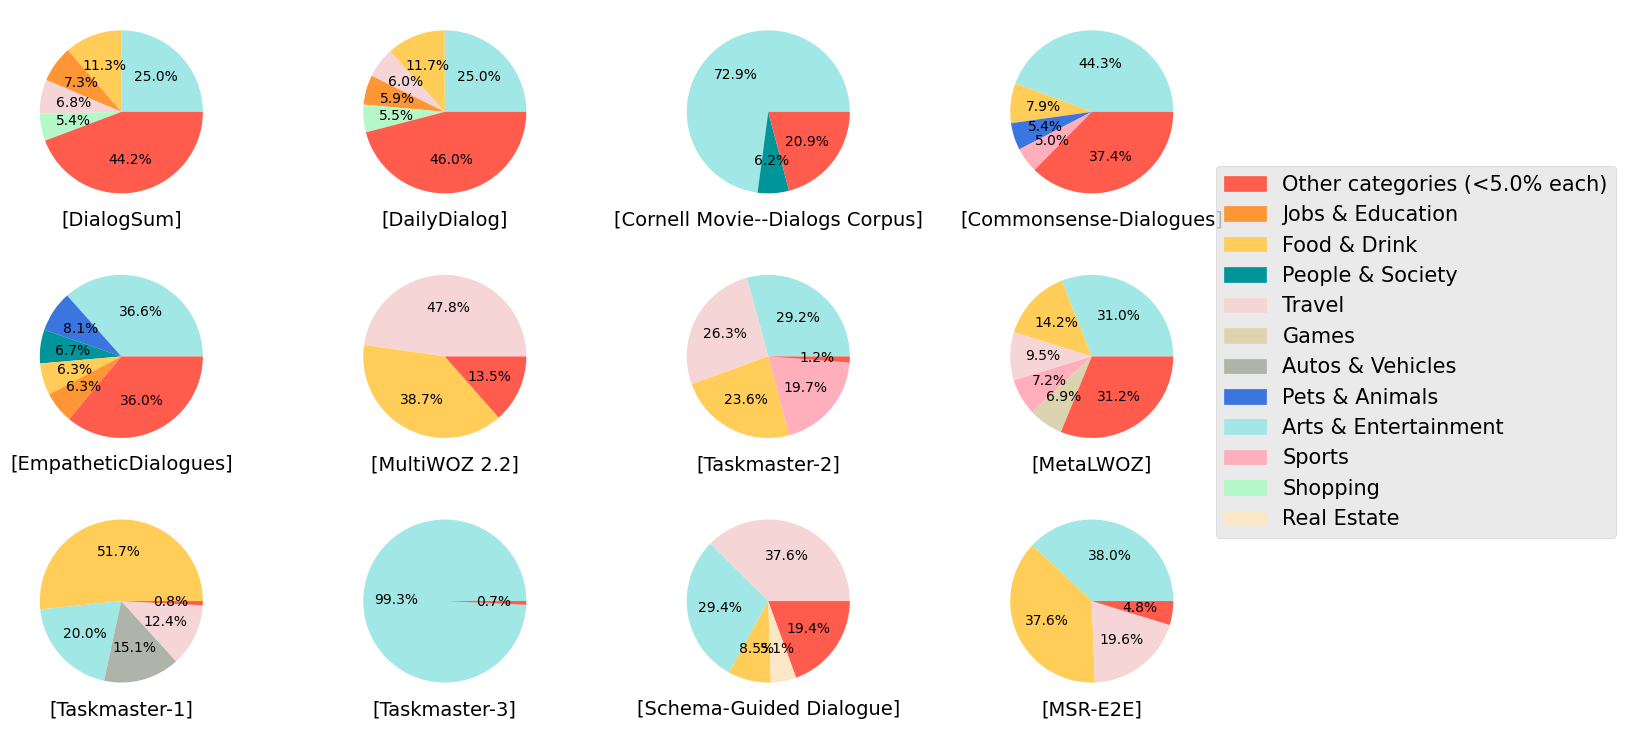

In [ ]:
# @title ## Google API Classification Results (on each dataset)
colors = [
    "#ff5c4d", "#ff9636", "#ffcd58", "#00959a", 
    "#F6D5D6", "#DCD3AF", "#AEB4AA", "#3a75e0",
    "#a0e7e5", "#ffaebc", "#b4f8c8", "#fbe7c6",
]

np.random.seed(SEED)
random.seed(SEED)

all_plot_labels = set()
color_mapper = dict()
for key in plot_dict:
    labels, _ = plot_dict[key]
    all_plot_labels |= set(labels)

all_plot_labels = list(all_plot_labels)

color_mapper = {all_plot_labels[i]:colors[i] for i in range(len(all_plot_labels))}

# second_colors = sns.color_palette("Paired")
# random.shuffle(second_colors)
# color_mapper = {all_plot_labels[i]:second_colors[i] for i in range(len(all_plot_labels))}

ncols = 4
nrows = int(np.ceil(len(plot_dict)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows))

for ax in axes.flat:
    ax.axis('off')

for ax, dataset_name in zip(axes.flat, plot_dict):
    labels, counts = plot_dict[dataset_name]
    chart_colors = [color_mapper[l] for l in labels]
    labels = list(labels)
    labels[-1] = "Other"
    labels = [l.split("&")[0] for l in labels]
    # labels = [l[:11] for l in labels]
    ax.pie(
        counts,
        autopct='%1.1f%%',
        colors=chart_colors,
        textprops={'fontsize': 10}
    )
          #  labels=labels,

    ax.set(aspect='equal')
    ax.set_title(f"[{dataset_name}]", y=-0.1, fontsize=14)

# plt.title("Google API classification results for each dataset")#, y=3.5, x=-0.6, fontsize=20)

leg = fig.legend(
    all_plot_labels, 
    loc='center right', 
    prop={'size': 15},
    bbox_to_anchor=[1.15, 0.5],
    bbox_transform=fig.transFigure,
)

for i, label in enumerate(all_plot_labels):
    leg.legendHandles[i].set_color(color_mapper[label])

# fig.suptitle("Classified Categories In Each Dataset", fontsize=20)
# plt.tight_layout()
plt.show()

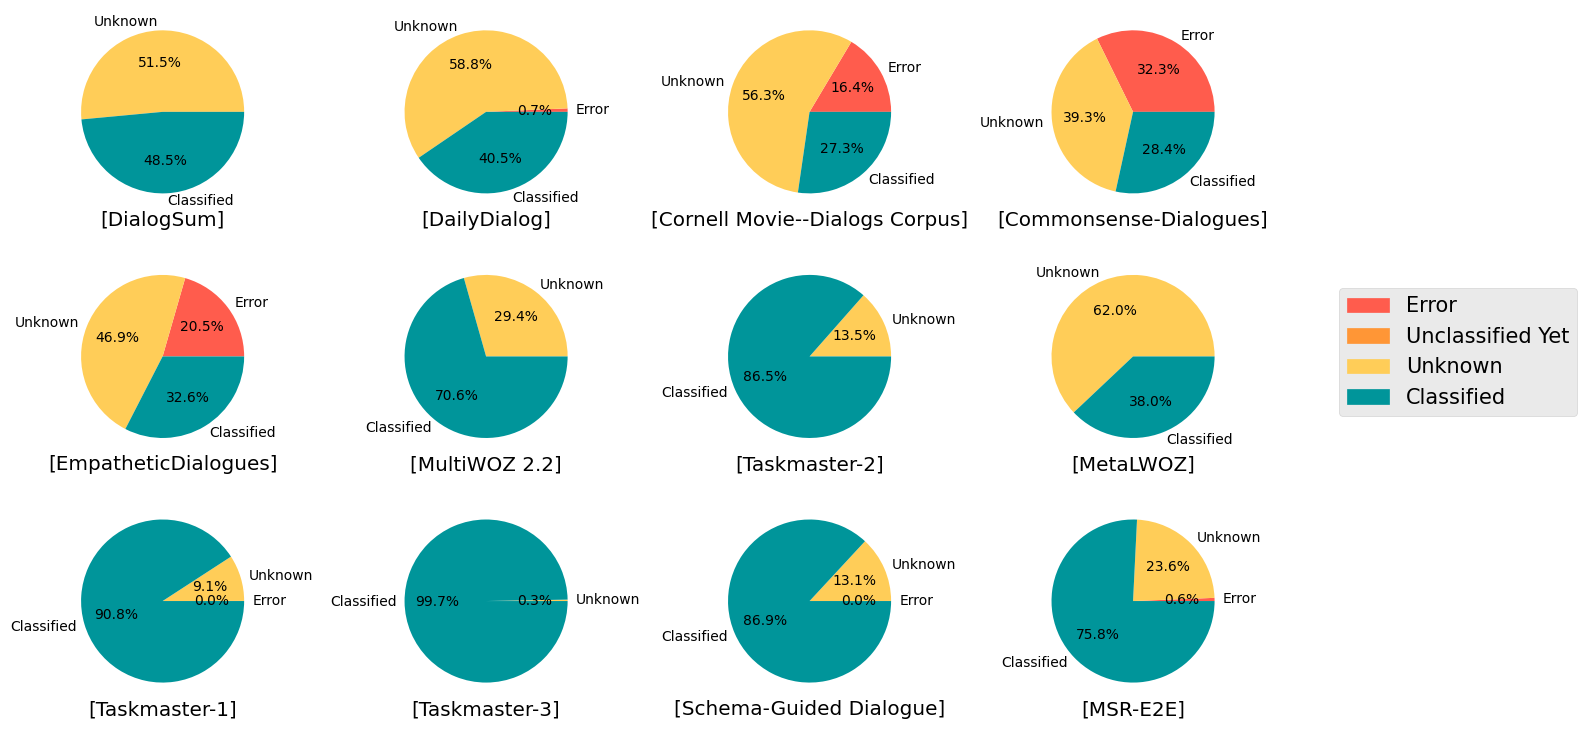

In [ ]:
# @title Classification Results (on each dataset)
np.random.seed(SEED)
random.seed(SEED)
colors = [
           "#F6D5D6", "#DCD3AF", "#AEB4AA", "#3a75e0",
           "#ff5c4d", "#ff9636", "#ffcd58", "#00959a", 
           "#a0e7e5", "#ffaebc", "#b4f8c8", "#fbe7c6",
]

all_plot_labels = list(unlabeled_dict[dataset_names[0]].keys())

color_mapper = {all_plot_labels[i]:colors[i+4] for i in range(len(all_plot_labels))}


ncols = 4
nrows = int(np.ceil(len(plot_dict)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows))

for ax in axes.flat:
    ax.axis('off')

for ax, dataset_name in zip(axes.flat, plot_dict):
    items = unlabeled_dict[dataset_name].items()
    items = [item for item in items if item[1]>1]
    labels, counts = list(zip(*items))

    ax.pie(counts, 
           labels=labels, 
           autopct='%1.1f%%',
           colors=[color_mapper[l] for l in labels])

    ax.set(aspect='equal')
    ax.set_title(f"[{dataset_name}]", y=-0.1)

# plt.title("Google API classification statistics for each dataset", y=3.5, x=-0.6, fontsize=20)

leg = fig.legend(
    all_plot_labels, 
    loc='center right', 
    prop={'size': 15},
    bbox_to_anchor=[1.1, 0.5],
    bbox_transform=fig.transFigure
)
for i, label in enumerate(all_plot_labels):
    leg.legendHandles[i].set_color(color_mapper[label])

# plt.tight_layout()
plt.show()

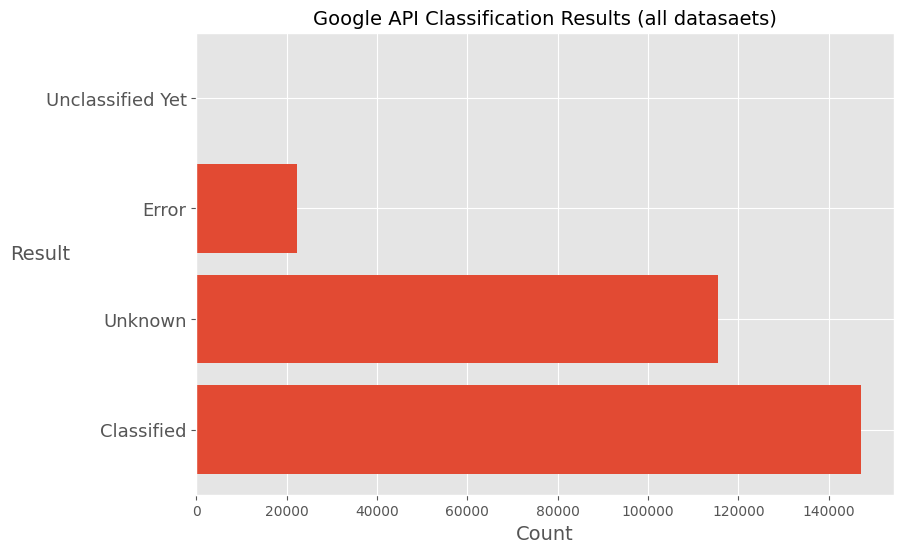


{'Error': 22229, 'Unknown': 115503, 'Classified': 147086, 'Unclassified Yet': 0}


In [ ]:
# @title Summary of Classification Results

unlabeled_pool = functools.reduce(lambda x, y: 
                                  {k:x.get(k, 0)+y.get(k, 0) 
                                  for k in set(x.keys()) | set(y.keys())}, 
                                  unlabeled_dict.values()
)

unlabeled_results = list(unlabeled_pool.items())
unlabeled_results.sort(key=lambda t: -t[1])

unlabeled_results_labels, unlabeled_results_counts = list(zip(*unlabeled_results))

plt.figure(figsize=(9, 6))
x_axis = list(range(len(unlabeled_results_counts)))

# plt.bar(x_axis, unlabeled_results_counts)
# plt.xticks(ticks=x_axis, labels=unlabeled_results_labels, rotation=80, fontsize=13)

plt.barh(x_axis, unlabeled_results_counts)
plt.yticks(ticks=x_axis, labels=unlabeled_results_labels, fontsize=13)

plt.title("Google API Classification Results (all datasaets)", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Result", fontsize=14, rotation=360)
# plt.tight_layout()
plt.show()

print()
print(unlabeled_pool)

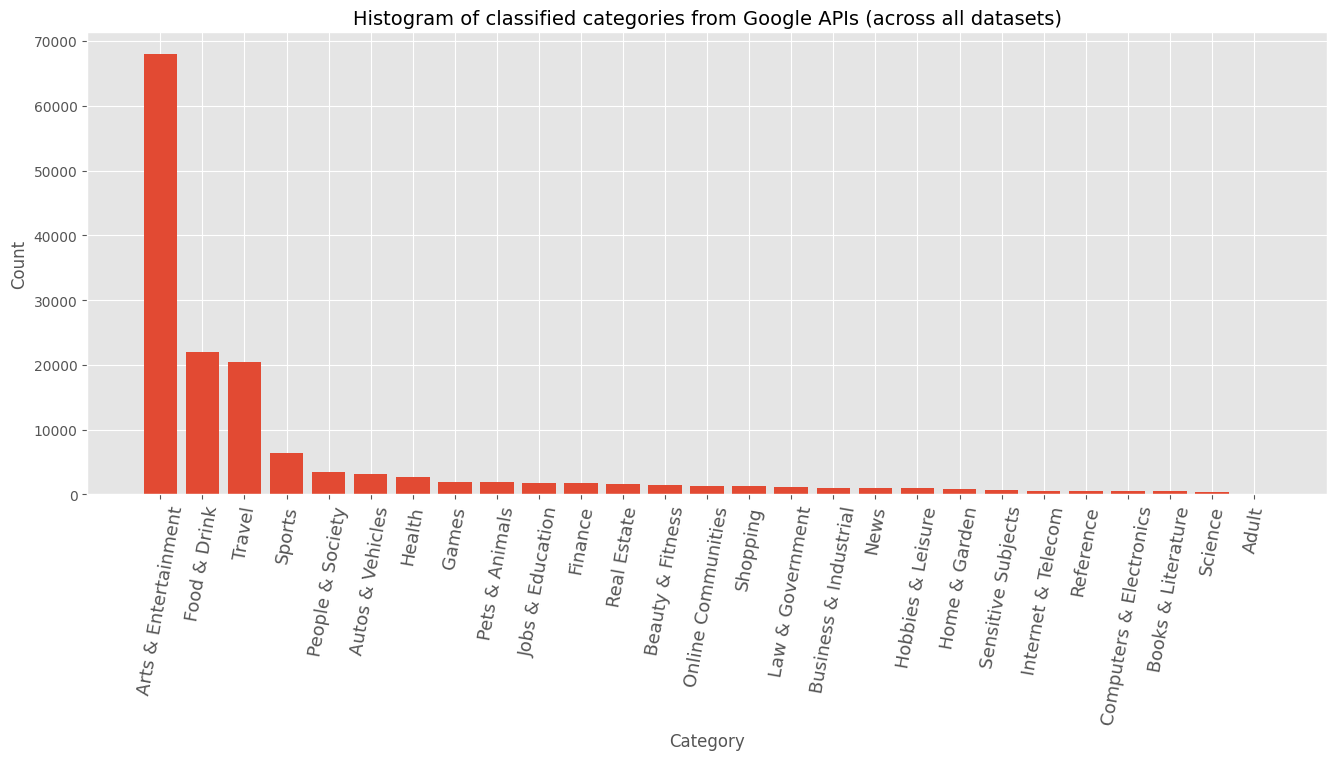

In [ ]:
# @title ## Highlighting Top Categories

categories_pool = functools.reduce(lambda x, y: 
                                   {k:x.get(k, 0)+y.get(k, 0) 
                                   for k in set(x.keys()) | set(y.keys())}, 
                                   classification_dicts
)

classified_categories = list(categories_pool.items())
classified_categories.sort(key=lambda t: -t[1])

classified_categories_labels, classified_categories_counts = list(zip(*classified_categories))

plt.figure(figsize=(16, 6))
x_axis = list(range(len(classified_categories_counts)))

plt.bar(x_axis, classified_categories_counts)
plt.xticks(ticks=x_axis, labels=classified_categories_labels, rotation=80, fontsize=13)

# plt.barh(x_axis, classified_categories_counts)
# plt.yticks(ticks=x_axis, labels=classified_categories_labels)

plt.title("Histogram of classified categories from Google APIs (across all datasets)", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [ ]:
# @title ## Merging The Top Categories

top_categories_to_select = 6 # @param {type:"integer"}
top_labels, _ = list(zip(*classified_categories[:top_categories_to_select]))

merged_df = pd.DataFrame(columns=["dialogue", "dataset", "topic", "subtopic1", "subtopic2"])

def get_subtopic(classification, level=0):
    topics = classification.split("/")
    return topics[level+1] if level+1 < len(topics) else np.nan

for dataset_name, dataset_df in zip(dataset_names, dfs):
    unclassified_mask = dataset_df['Google Classification']=="unclassified"
    unknown_mask      = dataset_df['Google Classification']=="unknown"
    error_mask        = dataset_df['Google Classification']=="error"

    not_nan_mask = ~(unclassified_mask|unknown_mask|error_mask)

    # get the classified rows onnly
    google_classification = dataset_df[not_nan_mask]['Google Classification']
    
    # remove subcategories
    parent_topic = google_classification.apply(get_subtopic)

    for topic_label in top_labels:
        topic_mask = parent_topic == topic_label
        topic_df = pd.DataFrame()
        topic_df['dialogue'] = dataset_df[not_nan_mask][topic_mask]['dialogue']
        topic_df['dataset'] = dataset_name
        topic_df['topic'] = topic_label
        topic_df['subtopic1'] = google_classification[topic_mask].apply(get_subtopic, args=(1,))
        topic_df['subtopic2'] = google_classification[topic_mask].apply(get_subtopic, args=(2,))

        merged_df = pd.concat([merged_df, topic_df])

merged_dataset_path = "MergedDataset" # @param {type:"string"}
merged_dataset_filename = "merged_dataset.csv" # @param {type:"string"}
os.makedirs(merged_dataset_path, exist_ok=True)
merged_df.to_csv(os.path.join(merged_dataset_path, merged_dataset_filename))

classified_but_not_used = unlabeled_pool['Classified']-merged_df.shape[0]
print()
print("Number of selected categories:", top_categories_to_select)
print(f"Classified but not included (minor categories): ~{formatter(classified_but_not_used)} dialogue")
print()

merged_df


Number of selected categories: 6
Classified but not included (minor categories): ~23K dialogue



,dialogue,dataset,topic,subtopic1,subtopic2
4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",DialogSum,Arts & Entertainment,NaN,NaN
12,#Person1#: Did Bean send these dirty jokes to ...,DialogSum,Arts & Entertainment,Humor,NaN
14,#Person1#: What kind of music do you like list...,DialogSum,Arts & Entertainment,Music & Audio,NaN
24,#Person1#: Out of every movie that you've seen...,DialogSum,Arts & Entertainment,Movies,NaN
25,#Person1#: What's all the security check about...,DialogSum,Arts & Entertainment,NaN,NaN
...,...,...,...,...,...
9845,#Person1#:Can I get a car for 4 on Friday nigh...,MSR-E2E,Autos & Vehicles,NaN,NaN
9911,#Person1#:April 16th at 4pm\n#Person2#:How man...,MSR-E2E,Autos & Vehicles,NaN,NaN
9948,#Person1#:Please send a fuel efficient vehicle...,MSR-E2E,Autos & Vehicles,NaN,NaN
10013,#Person1#:I need a ride to Hamm's Tires on S C...,MSR-E2E,Autos & Vehicles,Vehicle Parts & Services,Vehicle Parts & A


C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_21684\4214352521.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(subcategories, fontsize=14)
C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_21684\4214352521.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(subcategories, fontsize=14)
C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_21684\4214352521.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(subcategories, fontsize=14)
C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_21684\4214352521.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(subcategories, fontsize=14)
C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_21684\4214352521.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(subcategories, fontsize=14)
C:\Users\LAPTOP\AppData\Local\Temp\

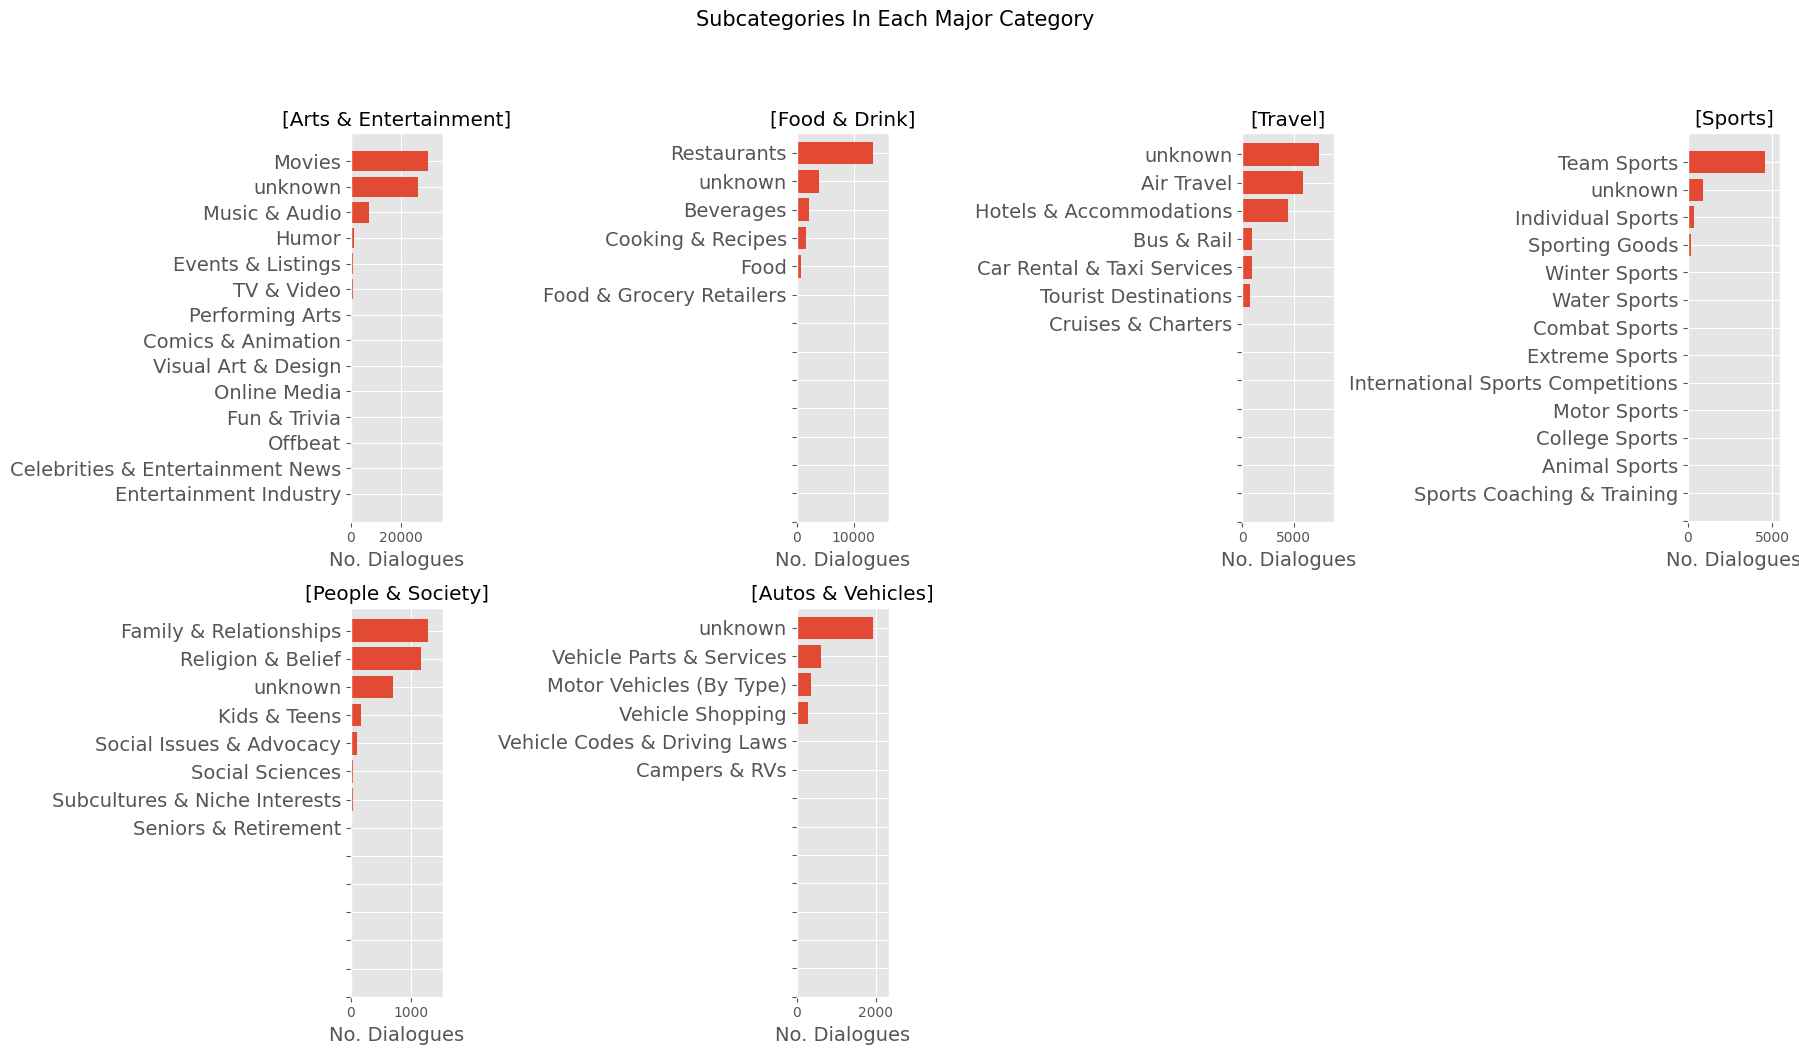

In [ ]:
# @title # Inspecting Subcategories

# inspecting the subcategories in each topic

ncols = 4
nrows = top_categories_to_select//ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5*nrows))

max_yticks = merged_df.groupby(by=['topic']).apply(lambda df: df['subtopic1'].unique().shape[0]).max()

for ax in axes.flat:
    ax.axis("off")

sorted_groups = sorted(
    merged_df.groupby(by='topic'), 
    key=lambda t: len(t[1]), 
    reverse=True
)

for ax, (_, category_df) in zip(axes.flat, sorted_groups):
    ax.axis("on")
    subcategories = category_df.groupby(by=["subtopic1"]).apply(len).to_dict()
    subcategories['unknown'] = len(category_df)-sum(subcategories.values())
    
    sorted_subcategories = sorted(subcategories.items(), key=lambda t: -t[1])
    subcategories, counts = list(zip(*sorted_subcategories))

    topic = category_df['topic'].iloc[0]
    max_count = max(counts) * 1.2

    ax.barh(subcategories, counts, height=0.8)
    ax.set_yticklabels(subcategories, fontsize=14)
    ax.set_yticks(range(max_yticks))
    ax.invert_yaxis()
    ax.set_title(f"[{topic}]")#, y=-0.2)
    ax.set_xlabel("No. Dialogues", fontsize=14)
    ax.set_xlim(0, max_count)

fig.suptitle("Subcategories In Each Major Category", fontsize=15, y=1.05)

plt.tight_layout()
plt.show()

In [ ]:
# @title ## Checking For NaN Values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123362 entries, 4 to 10044
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   dialogue   123362 non-null  object
 1   dataset    123362 non-null  object
 2   topic      123362 non-null  object
 3   subtopic1  81833 non-null   object
 4   subtopic2  13142 non-null   object
dtypes: object(5)
memory usage: 5.6+ MB


In [ ]:
# @title # Merged Dataset Statistics
merged_stats_dict = dict()

for topic_label in merged_df['topic'].unique():
    topic_mask = merged_df['topic'] == topic_label
    topic_df = merged_df[topic_mask]

    merged_stats_dict[topic_label] = dialogueUtils.get_stats(topic_df)

merged_stats_dict['Merged Dataset'] = dialogueUtils.get_stats(merged_df)

merged_stats_df = pd.DataFrame.from_dict(merged_stats_dict).astype(int).T
merged_stats_df['# dialogues'] = merged_stats_df['# dialogues'].apply(formatter)
merged_stats_df['# utterances'] = merged_stats_df['# utterances'].apply(formatter)

merged_stats_df

,# dialogues,# utterances,avg # turns in a dialogue,avg # words in a turn
Arts & Entertainment,67K,933K,13,10
Food & Drink,21K,351K,16,9
Travel,20K,387K,18,10
Sports,6K,82K,12,8
People & Society,3K,27K,7,12
Autos & Vehicles,3K,63K,19,9
Merged Dataset,123K,1.85M,14,9


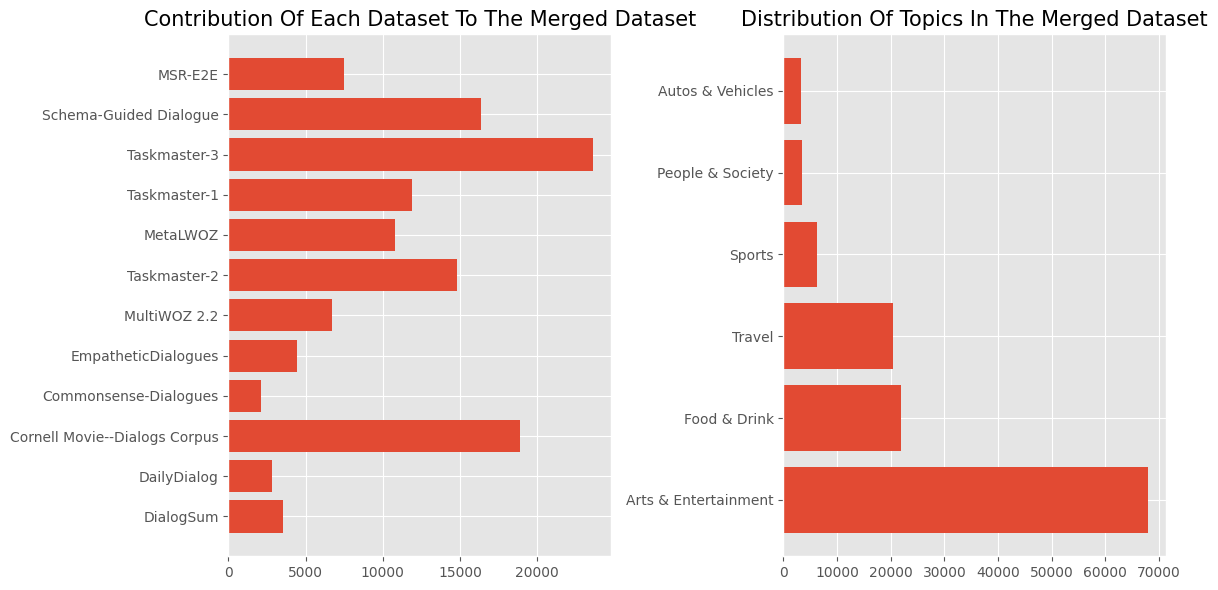

In [ ]:
# @title # Merged Dataset Distributions
def plot_distribution(df, col, title, ax):
    labels = list(df[col].unique())
    counts = [len(df[df[col]==label]) for label in labels]

    ax.barh(labels, counts)#, height=0.7)
    ax.set_title(title, fontsize=15)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot_distribution(merged_df, 'dataset', "Contribution Of Each Dataset To The Merged Dataset", axes[0])
plot_distribution(merged_df, 'topic', "Distribution Of Topics In The Merged Dataset", axes[1])
plt.tight_layout()
plt.show()

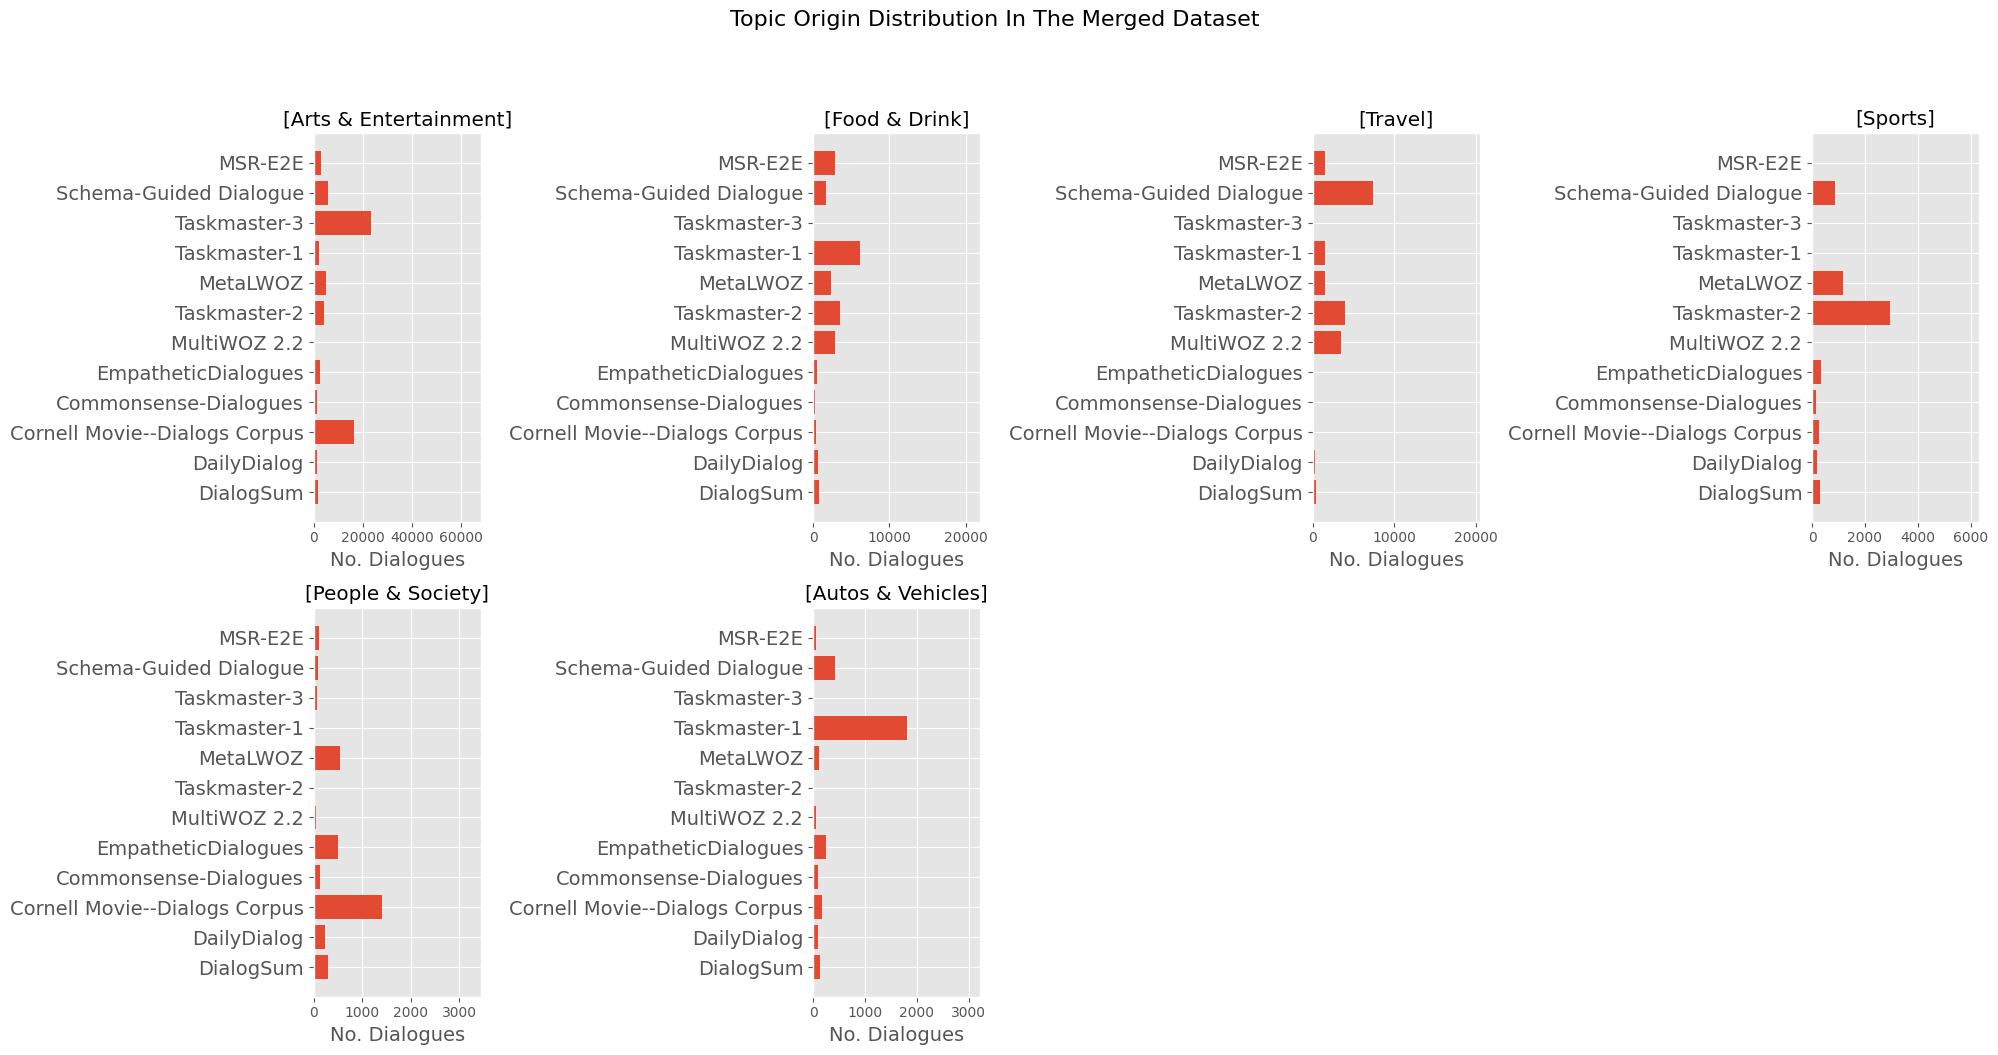

In [ ]:
# @title # Distribution Of Major Topics Over The Datasets
np.random.seed(SEED)
random.seed(SEED)

topics = merged_df['topic'].unique().tolist()
n_topics = len(topics)

grouped_df = merged_df.groupby(by=['topic', 'dataset']).apply(len)

# max_count = grouped_df.max()
# max_count = merged_df.shape[0]

ncols = 4
nrows = top_categories_to_select//ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,5*nrows))
for ax in axes.flat:
    ax.axis('off')

for ax, topic in zip(axes.flat, topics):
    ax.axis('on')
    topic_df = merged_df[merged_df['topic']==topic]
    counts = [topic_df[topic_df['dataset']==d].shape[0] for d in dataset_names]
    max_count = sum(counts)

    ax.barh(dataset_names, counts)
    ax.set_yticks(range(len(dataset_names)))
    ax.set_yticklabels(dataset_names, fontsize=14)

    ax.set_title(f"[{topic}]")#, y=-0.2)
    ax.set_xlabel("No. Dialogues", fontsize=14)
    ax.set_xlim(0, max_count)

fig.suptitle("Topic Origin Distribution In The Merged Dataset", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [ ]:
# @title # Dataset size at each filtration step
stages = ["Raw Dataset", "Google API Classification", "Merged Dataset"]

# "Top Categories Filtration"
funnel_df = pd.DataFrame()

for dataset_name, dataset_df in zip(dataset_names, dfs):

    unclassified_mask = dataset_df['Google Classification']=="unclassified"
    unknown_mask      = dataset_df['Google Classification']=="unknown"
    error_mask        = dataset_df['Google Classification']=="error"

    not_nan_mask = ~(unclassified_mask|unknown_mask|error_mask)

    categorized_df = dataset_df[not_nan_mask].copy()
    categorized_df['Google Classification'] = categorized_df['Google Classification'].apply(lambda x: x.split("/")[1])

    top_categories_mask = np.repeat(False, categorized_df.shape[0])

    for top_category in top_labels:
        top_categories_mask |= categorized_df['Google Classification']==top_category

    counts = [
              dataset_df.shape[0], # raw dataset rows
              categorized_df.shape[0], # categorized only
              categorized_df[top_categories_mask].shape[0], # top categories only
    ]

    df = pd.DataFrame(dict(dialogues=counts, Stage=stages))
    df['Dataset'] = dataset_name

    funnel_df = pd.concat([funnel_df, df])

fig = px.funnel(funnel_df, x='dialogues', y='Stage', color='Dataset')
fig.show()

In [ ]:
# @title # Utilization Of Each Dataset
treemap_df = pd.DataFrame()

get_result = lambda x: "Classified" if len(x.split("/"))>1 else x
get_parent_category = lambda x: x.split("/")[1] if len(x.split("/"))>1 else x

def get_category(x):
    parent = get_parent_category(x)
    if parent.lower() in ["unclassified", "error", "unknown"]:
        return ""

    return parent.split(" ")[0] if parent in top_labels else "Other"

for dataset_name, dataset_df in zip(dataset_names, dfs):
    dataset_stats_df = pd.DataFrame()
    dataset_stats_df['Classification Result'] = dataset_df['Google Classification'].apply(get_result).apply(str.capitalize)
    dataset_stats_df['Category'] = dataset_df['Google Classification'].apply(get_category)
    dataset_stats_df['Dataset'] = dataset_name

    treemap_df = pd.concat([treemap_df, dataset_stats_df])

fig = px.treemap(treemap_df,
                 path=[px.Constant("Merged Dataset"), 'Dataset', 'Classification Result', 'Category'], 
                 color='Category'
)
                #  path=['Dataset', 'Classification Result', 'Category'], 

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()